# pibit empresa 'SELEÇÃO DE CARACTERÍSTICAS PARA PREVISÃO DO DESEMPENHO DE ALUNOS EM CURSOS DE EAD'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# %%
# Read the data
students_data = pd.read_csv('student-por.csv', sep=';', true_values=['yes'], false_values=['no'])
students_data.sample(5)


In [3]:
# Add boolean column PassFail
def passfail(row):
    if row['G3'] >= 10:
        return True
    else:
        return False


students_data['PassFail'] = students_data.apply(lambda row: passfail(row), axis=1)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
439,MS,F,15,R,GT3,T,3,3,other,services,...,4,1,3,1,1,4,0,14,16,16
441,MS,M,17,U,GT3,T,1,1,other,other,...,4,4,3,2,4,5,4,8,9,9
525,MS,M,17,U,LE3,T,4,4,other,services,...,4,4,3,1,2,5,0,15,14,16
557,MS,F,17,R,GT3,T,3,1,other,other,...,5,4,4,1,1,5,2,7,9,10
54,GP,F,15,U,LE3,A,3,3,other,other,...,5,3,4,4,4,1,0,13,12,13


In [4]:
# data visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
students_data.G3.hist(ax=axes[0])
axes[0].set_title("Distribuição de G3")
sns.countplot(x="PassFail", data=students_data, ax=axes[1])
axes[1].set_title("Distribuição entre Aprovados/Reprovados")
plt.grid(True, axis='y')
# plt.show()

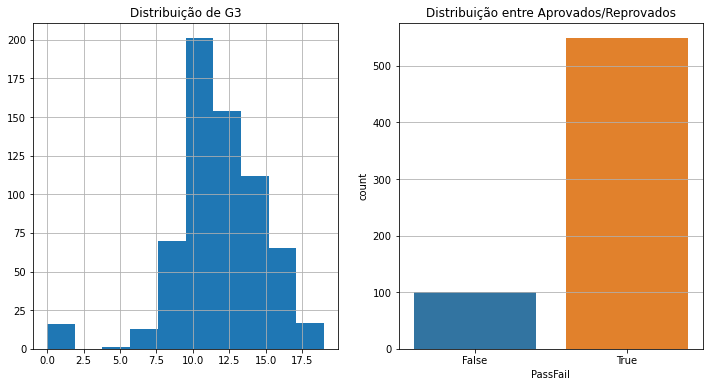

In [5]:
# Separate target from predictors
Y = students_data.PassFail
X = students_data.drop(['absences', 'G1', 'G2', 'G3', 'PassFail'], axis=1)


In [ ]:
def conf_matrix(prediction, Y_validation):
    """ Confusion Matrix for dataset predictions
    :type Y_validation: dataframe
    :type prediction: dataframe
    """
    y_valid = [i for i in Y_validation]
    truepred = [0, 0]
    falsepred = [0, 0]
    for i in range(len(prediction)):
        if prediction[i]:
            if prediction[i] == y_valid[i]:
                truepred[0] += 1
            else:
                truepred[1] += 1
        else:
            if prediction[i] != y_valid[i]:
                falsepred[0] += 1
            else:
                falsepred[1] += 1
    return pd.DataFrame(np.array([truepred, falsepred]), columns=['True', 'False'], index=['TruePred', 'FalsePred'])


In [ ]:
"""def scale_numeric(data, numeric_columns, scale):
    for col in numeric_columns:
        data[col] = scale.fit_transform(data[col].values.reshape(-1, 1))
    return data


# We can now define the scaler we want to use and apply it to our dataset
scaler = StandardScaler()
X = scale_numeric(X, [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']], scaler)"""

In [ ]:
# columns types
students_num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
students_cat_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and X[cname].dtype == "object"]
students_bool_cols = [cname for cname in X.columns if X[cname].dtype == "bool"]

# Keep selected columns only
my_cols = students_cat_cols + students_num_cols + students_bool_cols
X = X[my_cols].copy()

In [ ]:
# Divide data into training and validation subsets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, stratify=Y,
                                                      shuffle=True)
# Get shape of test and training sets
print('Training Set:')
print('Number of datapoints: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('Test Set:')
print('Number of datapoints: ', X_valid.shape[0])
print('Number of features: ', X_valid.shape[1])

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('filter', SelectKBest(mutual_info_classif, k='all'))])
# Preprocessing for boolean data
boolean_transformer = VarianceThreshold(threshold=0.8 * (1 - 0.8))

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, students_num_cols),
        ('cat', categorical_transformer, students_cat_cols),
        ('bool', boolean_transformer, students_bool_cols)])

In [ ]:
# Choose model
model1 = DecisionTreeClassifier(criterion='entropy')
model2 = RandomForestClassifier(n_estimators=100)
model3 = LogisticRegression(solver='lbfgs')
voting_clf = VotingClassifier(estimators=[('dt', model1), ('rf', model2), ('lr', model3)],
                              # here we select soft voting, which returns the argmax of the sum of
                              # predicted probabilities
                              voting='soft', weights=[1, 1, 1])
models = [model1, model2, model3, voting_clf]

In [ ]:
# Decision Tree Classifier
print('Decision Tree Classifier')
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[0])])
my_pipeline.fit(X_train, Y_train)
preds = my_pipeline.predict(X_valid)
print("Confusion Matrix:\n", conf_matrix(preds, Y_valid))
score = accuracy_score(Y_valid, preds)
print("Accuracy score without xvalidation:\n", score)
scores = cross_val_score(my_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
print("Accuracy scores:\n", scores)
mean = scores.mean()
print(mean)
print('End of model')

In [ ]:
# Random Forest Classifier
print('Random Forest Classifier')
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[1])])
my_pipeline.fit(X_train, Y_train)
preds = my_pipeline.predict(X_valid)
print("Confusion Matrix:\n", conf_matrix(preds, Y_valid))
score = accuracy_score(Y_valid, preds)
print("Accuracy score without xvalidation:\n", score)
scores = cross_val_score(my_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
print("Accuracy scores:\n", scores)
mean = scores.mean()
print(mean)
print('End of model')

In [ ]:
# Logistic Regression
print('Logistic Regression')
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[2])])
my_pipeline.fit(X_train, Y_train)
preds = my_pipeline.predict(X_valid)
print("Confusion Matrix:\n", conf_matrix(preds, Y_valid))
score = accuracy_score(Y_valid, preds)
print("Accuracy score without xvalidation:\n", score)
scores = cross_val_score(my_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
print("Accuracy scores:\n", scores)
mean = scores.mean()
print(mean)
print('End of model')

In [ ]:
# Voting Classifier
print('Voting Classifier')
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[3])])
my_pipeline.fit(X_train, Y_train)
preds = my_pipeline.predict(X_valid)
print("Confusion Matrix:\n", conf_matrix(preds, Y_valid))
score = accuracy_score(Y_valid, preds)
print("Accuracy score without xvalidation:\n", score)
scores = cross_val_score(my_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
print("Accuracy scores:\n", scores)
mean = scores.mean()
print(mean)
print('End of model')